In [1]:
import cv2
import numpy as np
import  kociemba
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import skimage as sk
import skimage.io as skio
import scipy.cluster
import sklearn.cluster
import math

In [3]:
def show_img (img):
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    rbg_pic = np.dstack([r,g,b])
    plt.imshow(rbg_pic)
    plt.show()
    

# Manual selector three points to locate the cube for now.
# Switch to auto Later 

def manual_sel_ptr(img):
    %matplotlib qt
    pic_f = sk.img_as_float(img)
    plt.imshow(pic_f)
    pts = np.asarray(plt.ginput(-1, timeout=60))
    %matplotlib inline
    min_x = pts[0][0]
    max_x = pts[1][0]
    min_y = pts[0][1]
    max_y = pts[2][1]
    return (min_x , max_x, min_y, max_y)

# Crop the image into base on the args 
def crop_img (img, min_x, max_x, min_y, max_y):
    img = sk.img_as_float(img)
    
    crop = img[int(min_y): int(max_y), int(min_x) : int(max_x)]
    return crop

# Tiles to image into 3x3
def tile_img_9(img):
    M = img.shape[0]//3
    N = img.shape[1]//3
    tiles = []
    for x in range(0,img.shape[0],M):
        for y in range(0,img.shape[1], N):
            if (x + M > img.shape[0] or y + N > img.shape[1]):
                continue
            tiles.append(img[x:x+M,y:y+N])
    return tiles

# Using the Knn to find the most dominate color in a giving img
def dominant_colors(image):
    image = cv2.resize(image, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    kmeans = sklearn.cluster.MiniBatchKMeans(
        n_clusters=5,
        init="k-means++",
        max_iter=20,
        random_state=1000
    ).fit(ar)
    codes = kmeans.cluster_centers_

    vecs, _dist = scipy.cluster.vq.vq(ar, codes)
    counts, _bins = np.histogram(vecs, len(codes))

    colors = []
    for index in np.argsort(counts)[::-1]:
        colors.append(tuple([int(code) for code in codes[index]]))
    return colors

color_palette = {
            'red'   : (0, 0, 255),
            'orange': (0, 165, 255),
            'blue'  : (255, 0, 0),
            'green' : (0, 255, 0),
            'white' : (255, 255, 255),
            'yellow': (0, 255, 255)
}

# least Square to find the corresponding color
def closest_color(bgr):
    b, g, r = bgr
    color_diffs = []
    for name, color in color_palette.items():
        cb, cg, cr = color
        color_diff = np.sqrt((r - cr)**2 + (g - cg)**2 + (b - cb)**2)
        color_diffs.append((color_diff, name))
    return min(color_diffs)[1]


def edge_img(img, low_threshold, high_threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges

def find_lines(edge_img, threshold, min_line_length, max_line_gap):
    lines = []
    rho = 1
    theta = np.pi/180
    line_image = np.copy(image)
    lines = cv2.HoughLinesP(edge_img, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    if (type(lines) == type(None)):
        return []
    return lines

def find_candi(lines, threashold):
    candi = []
    for i in lines:
        for j in lines:
            if ((i == j).all()):
                continue
            if (abs(i[0][0] - j[0][0]) < threashold and abs(i[0][1] - j[0][1]) < threashold):
                candi.append((i,j))
            elif (abs(i[0][0] - j[0][2]) < threashold and abs(i[0][1] - j[0][3]) < threashold):
                candi.append((i,j)) 
    real_can = []        
    for pair in candi:
        line1 = pair[0][0]
        line2 = pair[1][0]
        a1 = math.atan2(line1[3]-line1[1],line1[2]-line1[0])
        a2 = math.atan2(line2[3]-line2[1],line2[2]-line2[0])
        if a1<0:a1+=np.pi
        if a2<0:a2+=np.pi
        ang=abs(abs(a2-a1)-np.pi/2)
        lenght1 = math.sqrt(((line1[0]-line1[2])**2)+((line1[1]-line1[3])**2))
        lenght2 = math.sqrt(((line2[0]-line2[2])**2)+((line2[1]-line2[3])**2))
        if ang < 0.5 and abs(lenght1 - lenght2) < threashold:
            real_can.append(pair)
    return real_can

def find_corner(candi):
    xs = []
    ys = []
    for pair in candi:
        for line in pair:
            for x1,y1,x2,y2 in line:
                xs += [x1, x2]
                ys += [y1, y2]
    max_x = max(xs)
    min_x = min(xs)
    min_y = min(ys)
    max_y = max(ys)
    return min_x, max_x, min_y, max_y

In [18]:
cap = cv2.VideoCapture(1)
ret, image = cap.read()
image = cv2.resize(image, (250, 150), interpolation = cv2.INTER_AREA)
if not ret:
    print("Can't receive frame (stream end?). Exiting ...")

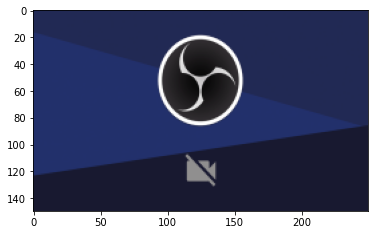

In [19]:
show_img(image)

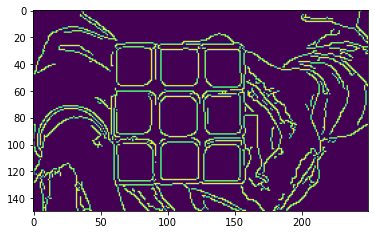

0


ValueError: max() arg is an empty sequence

In [17]:
edge = edge_img(image, 10, 100)
plt.imshow(edge)
plt.show()
lines = find_lines(edge, 20, 80, 10)
candi = find_candi(lines, 5)
print(len(candi))
pts = find_corner(candi)

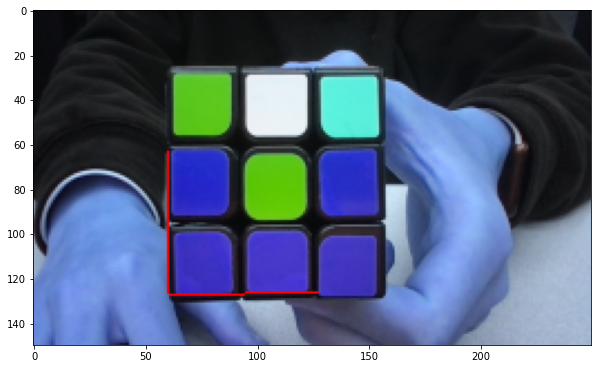

In [15]:
line_image = np.copy(image)
for pair in candi:
    for line in pair:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),1)
plt.figure(figsize=(10,10))
plt.imshow(line_image)

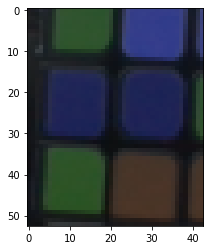

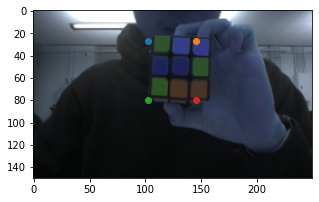

In [11]:
min_x , max_x, min_y, max_y = pts
crop = image[min_y:max_y, min_x:max_x]
plt.imshow(crop)
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.scatter(min_x, min_y)
plt.scatter(max_x, min_y)
plt.scatter(min_x, max_y)
plt.scatter(max_x, max_y)
plt.show()

In [12]:
print(pts)

(102, 145, 27, 80)


In [88]:
# min_x , max_x, min_y, max_y = pts
# plt.figure(figsize=(5, 5))
# plt.imshow(rbg_pic)
# plt.scatter(min_x, min_y)
# plt.scatter(max_x, min_y)
# plt.scatter(min_x, max_y)
# plt.scatter(max_x, max_y)
# plt.scatter(*pts[0])
# plt.show()

In [35]:
crop = crop_img(image, *pts)

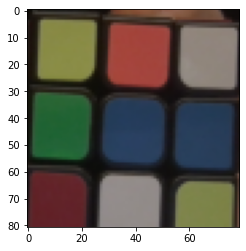

In [36]:
show_img(crop)

In [49]:
tiles = tile_img_9(crop)

[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]
[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]


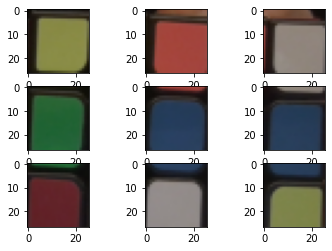

In [56]:
for i, t in enumerate(tiles):
    plt.subplot(3,3,i + 1)
    r = t[:,:,2]
    g = t[:,:,1]
    b = t[:,:,0]
    rbg_pic = np.dstack([r,g,b])
    colors = dominant_colors(t)
    print(colors)
    plt.imshow(rbg_pic)
plt.show()

In [48]:
colors = dominant_colors(tiles[4])
colors

[(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)]

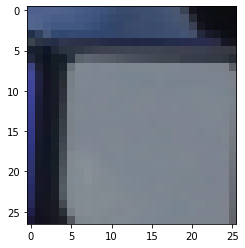

In [42]:
plt.imshow(tiles[2])

In [32]:
face_color = []
for i in tiles:
    colors = dominant_colors(i)
    face_color.append(closest_color(colors[0]))
face_color

['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']

In [4]:
cap = cv2.VideoCapture(1)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    ret, image = cap.read()
    image = cv2.resize(image, (250, 150), interpolation = cv2.INTER_AREA)
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        exit()
    edge = edge_img(image, 50, 80)
    cv2.imshow('frame', image)
    cv2.waitKey(1)
    lines = find_lines(edge, 20, 40, 10)
    if (len(lines) == 0):
        cv2.waitKey(1)
        continue
    candi = find_candi(lines, 5)
    if (len(candi) == 0):
        cv2.waitKey(1)
        continue
    line_image = np.copy(image)
    for pair in candi:
        for line in pair:
            for x1,y1,x2,y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),1)
    cv2.imshow('frame', line_image)
    cv2.waitKey(1)
    pts = find_corner(candi)
    min_x , max_x, min_y, max_y = pts
    crop = image[min_y:max_y, min_x:max_x]
    tiles = tile_img_9(crop)
    colors = dominant_colors(tiles[4])
    face_color = []
    for i in tiles:
        colors = dominant_colors(i)
        face_color.append(closest_color(colors[0]))
    print(face_color)

['green', 'red', 'red', 'green', 'green', 'red', 'red', 'red', 'red']
['green', 'white', 'yellow', 'red', 'green', 'red', 'red', 'red', 'red']
['red', 'red', 'green', 'red', 'red', 'green', 'red', 'red', 'red']
['red', 'green', 'white', 'white', 'red', 'red', 'orange', 'orange', 'orange']
['red', 'green', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
['red', 'red', 'red', 'red', 'red', 'red', 'white', 'orange', 'orange']
['green', 'white', 'white', 'green', 'green', 'white', 'red', 'green', 'green']
['green', 'white', 'white', 'red', 'green', 'green', 'red', 'red', 'red']
['orange', 'orange', 'red', 'orange', 'orange', 'orange', 'white', 'orange', 'red']
['white', 'red', 'red', 'orange', 'red', 'white', 'orange', 'orange', 'orange']
['white', 'white', 'yellow', 'green', 'green', 'red', 'green', 'green', 'red']
['white', 'white', 'yellow', 'green', 'red', 'red', 'green', 'green', 'red']
['white', 'white', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
['green',

KeyboardInterrupt: 